In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import scipy.special
import math
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

##Load Data##
from ReadAndCleanData import train_csv, test_csv, submission_csv, structures_csv

Loading Data...
Data Captured


In [3]:
#Let's see what kind of data we are dealing with
print("train file has shape:", train_csv.shape)
print("test file has shape:", test_csv.shape)
print("structures file has shape:", structures_csv.shape)


train file has shape: (4658147, 6)
test file has shape: (2505542, 5)
structures file has shape: (2358657, 6)


In [4]:
print(train_csv.head(5))

       molecule_name  molecule_index  atom_index_0  atom_index_1  type  scalar_coupling_constant
id                                                                                              
0   dsgdb9nsd_000001  1               1             0             1JHC  84.807602               
1   dsgdb9nsd_000001  1               1             2             2JHH -11.257000               
2   dsgdb9nsd_000001  1               1             3             2JHH -11.254800               
3   dsgdb9nsd_000001  1               1             4             2JHH -11.254300               
4   dsgdb9nsd_000001  1               2             0             1JHC  84.807404               


In [5]:
print(structures_csv.head(5))

   molecule_index  atom_index  atom         x         y         z
0  1               0           6    -0.012698  1.085804  0.008001
1  1               1           1     0.002150 -0.006031  0.001976
2  1               2           1     1.011731  1.463751  0.000277
3  1               3           1    -0.540815  1.447527 -0.876644
4  1               4           1    -0.523814  1.437933  0.906397


count    4.658147e+06
mean     1.592164e+01
std      3.494198e+01
min     -3.621860e+01
25%     -2.549780e-01
50%      2.281130e+00
75%      7.390655e+00
max      2.048800e+02
Name: scalar_coupling_constant, dtype: float64


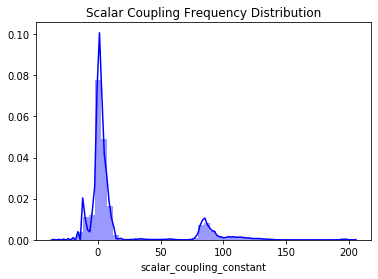

In [6]:
# We aim to analyze and predict the scalar_coupling_constant for arbitrary atoms
# Let's investigate this quantity in the training data

print(train_csv['scalar_coupling_constant'].describe())
sns.distplot(train_csv['scalar_coupling_constant'], color = 'blue')
plt.title("Scalar Coupling Frequency Distribution")
plt.show()

In [7]:
bond_types = train_csv["type"].unique()
num = len(bond_types)
print(f"There are {num} bonding types to be considered.")


There are 8 bonding types to be considered.


In [8]:
#for bond_type in bond_types:
#    print(f"The scalar coupling constants for bond type {bond_type} can be described by")
#    print(train_csv[train_csv['type']==bond_type]['scalar_coupling_constant'].describe())

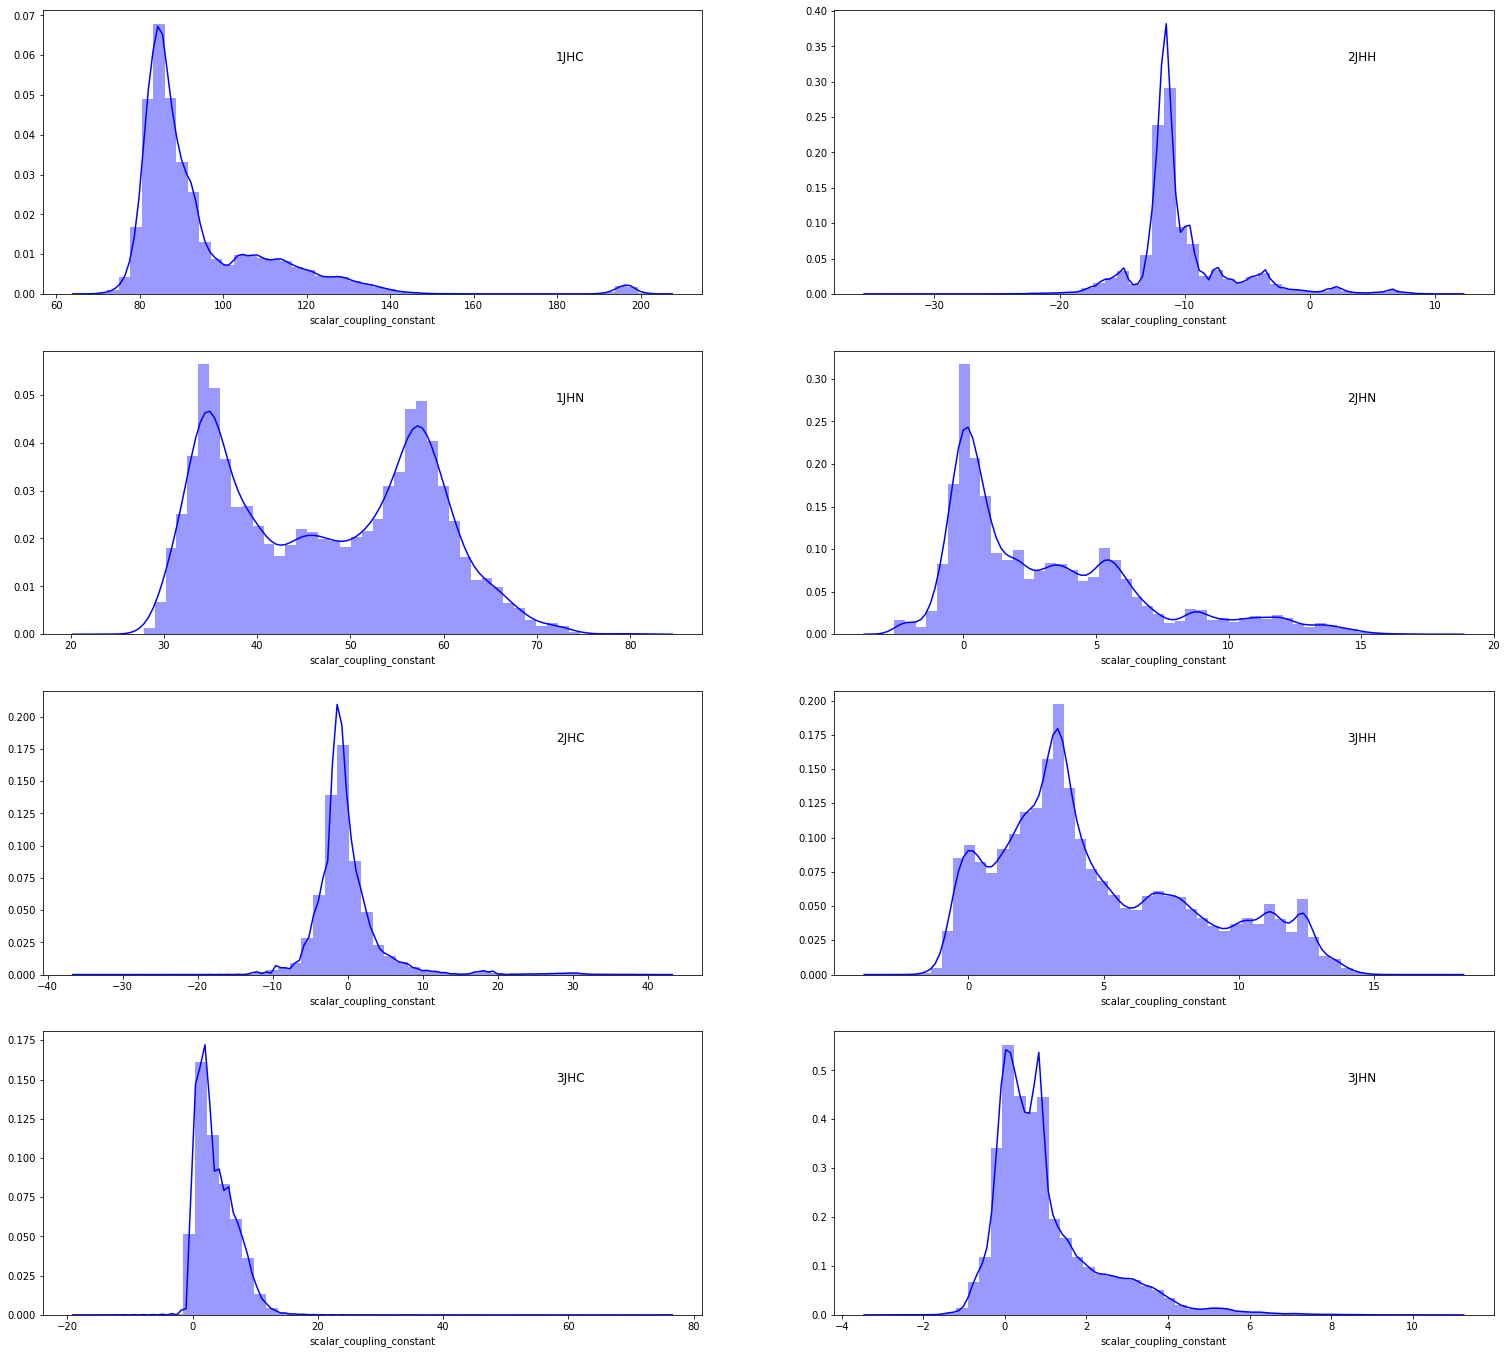

In [9]:
plt.figure(figsize=(26, 24))
for i, bond_type in enumerate(bond_types):
    plt.subplot(4, 2, i + 1)
    sns.distplot(train_csv[train_csv['type'] == bond_type]['scalar_coupling_constant'], color='blue')
    plt.title(bond_type, x=.8, y=.8)
plt.show()

Let's consider some basic features that might help in predicting the scalar coupling,
and see how they are correlated with the coupling constant. For each feature, we will consider the relation to the scalar coupling constant one bond type at a time, since we expect different bond types to have scalar couplings affected by a given feature in different ways. We restrict attention to the coupling type '1JHN' for now, and later will loop our considerations over all coupling types

In [10]:
## Let's load some feature functions we will use
import FeatureFunctions as FF

# Make a copy of the train data. We will add our features to this copy
train_df = train_csv.copy(deep=True)

# build_type_dataframes queries the subset of its argument corresponding to the coupling type in question
train_df_1jhn, structures = FF.build_type_dataframes(train_df, structures_csv, coupling_type='1JHN')

# add_coordinates merges the position data for the two atoms in question into 
train_df_1jhn = FF.add_coordinates(train_df_1jhn, structures, 0)
train_df_1jhn = FF.add_coordinates(train_df_1jhn, structures, 1)

# Check the output
#print(train_df_1jhn.head(20))

Feature 1: Bond distance

This is just the physical distance between the two atoms in a given molecule whose scalar coupling we want to calculate. We use the structure data for the molecules to add this feature to the train data. 

In [11]:
## We use the add_distance_between function to calculate the distance between the two atoms
## in question for each coupling pair

FF.add_distance_between(train_df_1jhn, 1,0)

## Check added information
#print(train_df_1jhn['d_1_0'].head(20))


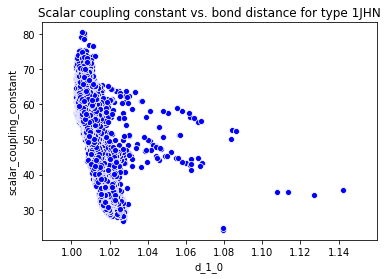

In [12]:
sns.scatterplot(x = 'd_1_0', y='scalar_coupling_constant',data=train_df_1jhn[['scalar_coupling_constant', 'd_1_0']], color = 'blue')
plt.title("Scalar coupling constant vs. bond distance for type 1JHN")
plt.show()

The bond distance appears to be mostly linearly correlated with the coupling constant for this bond type. This should prove very useful!

Feature 2: Local Valences of Atoms in Question

We consider the complete graph on all of the atoms in each molecule. We then focus attention on the particular atoms whose coupling constant we want to predict, and add a feature which calculates the total number of edges completely contained in a small (small=epsilon * bond distance) neighborhood of the atom. We compute this for both of the atoms involved in the coupling in question, and add it as a feature f'{atomnumber}_local_valence_{epsilon}'

In [13]:
## Import pipeline to construct dataset with distances from all atoms in given molecule to the two atoms in question
## Credit for this implementation: Kaggle user 
import BuildFeatureDataFrame as B

n_atoms=4
train_df_1jhn = B.build_couple_dataframe_with_dists(train_df,structures_csv,coupling_type = '1JHN', n_atoms = 7)
train_df_1jhn_dists = train_df_1jhn.loc[:, (f'd_{i}_{j}' for i in range(n_atoms) for j in range(min(i,4)))]
print(train_df_1jhn_dists.head(10))



      d_1_0     d_2_0     d_2_1     d_3_0     d_3_1     d_3_2
0  1.017190  1.618523  1.017187  1.618710  1.017208  1.618706
1  1.017187  1.618523  1.017190  1.618706  1.017208  1.618710
2  1.017208  1.618706  1.017187  1.618710  1.017190  1.618523
3  1.007511  1.734777  1.004933  2.050487  1.359838  2.071779
4  1.004933  1.734777  1.007511  2.071779  1.359838  2.050487
5  1.004771  1.727509  1.006952  2.084700  1.369356  2.043309
6  1.006952  1.727509  1.004771  2.043309  1.369356  2.084700
7  1.014969  1.631013  1.015277  2.035264  1.463593  2.046443
8  1.015277  1.631013  1.014969  2.046443  1.463593  2.035264
9  1.004448  2.115390  1.372028  2.115394  1.372027  2.245993


In [14]:
## Define the local valence count at atom_0 and atom_1
def add_local_valence_0(df, epsilon, n_atoms):
    #requires epsilon >=1 to be topological
    #Consider all edges corresponding to distances from  vertices to vertex 0
    edges = df[[f'd_{n}_0' for n in range(1,n_atoms)]].copy(deep=True)
    for n in range(1,n_atoms):
        edges[f'd_{n}_0'] = np.where(edges[f'd_{n}_0'] <= edges['d_1_0'].multiply(epsilon), 1, 0)
    edges_to_zero = edges.sum(axis=1) 
    
    df[f'0_local_valence_{epsilon}'] = edges_to_zero
    
def add_local_valence_1(df, epsilon, n_atoms):
    #requires epsilon >=1 to be topological
    #Consider all edges corresponding to distances from  vertices to vertex 0
    edges = df[[f'd_{n}_1' for n in range(2,n_atoms)]].copy(deep=True)
    edges['d_1_1'] = df['d_1_0']
    for n in range(1,n_atoms):
        edges[f'd_{n}_1'] = np.where(edges[f'd_{n}_1'] <= edges['d_1_1'].multiply(epsilon), 1, 0)
    edges_to_one = edges.sum(axis=1) 
    
    df[f'1_local_valence_{epsilon}'] = edges_to_one

In [15]:
add_local_valence_0(train_df_1jhn,1.8,n_atoms)
add_local_valence_1(train_df_1jhn,1.8,n_atoms)



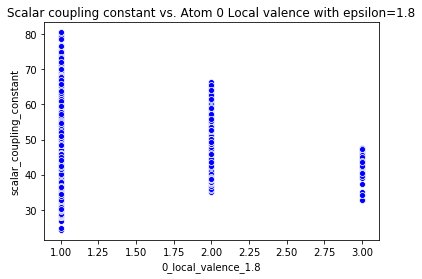

In [16]:
sns.scatterplot(x = '0_local_valence_1.8', y='scalar_coupling_constant',data=train_df_1jhn[['scalar_coupling_constant', '0_local_valence_1.8']], color = 'blue')
plt.title("Scalar coupling constant vs. Atom 0 Local valence with epsilon=1.8")
plt.show()

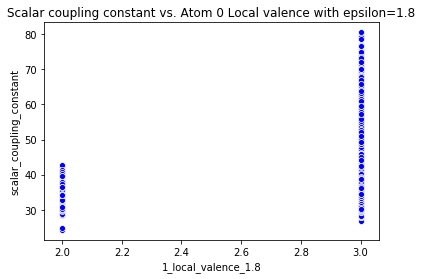

In [17]:
sns.scatterplot(x = '1_local_valence_1.8', y='scalar_coupling_constant',data=train_df_1jhn[['scalar_coupling_constant', '1_local_valence_1.8']], color = 'blue')
plt.title("Scalar coupling constant vs. Atom 0 Local valence with epsilon=1.8")
plt.show()

There appears to be some separation of coupling values based on local valencies. However, as some quick testing shows, this is very sensitive to the choice of epsilon. Need to find optimal values of epsilon for each coupling type.

Feature 3: Local Weight

We consider the total atomic weight of the k neighbors nearest to the center of the bonding pair. 

In [18]:
n_atoms = 9
train_df_2jhh = B.build_couple_dataframe_with_dists(train_df,structures_csv,coupling_type = '2JHH', n_atoms = 9)

train_df_2jhh_atoms = train_df_2jhh.loc[:, (f'atom_{i}' for i in range(2,n_atoms))]
print(train_df_2jhh_atoms.head(10))

   atom_2  atom_3  atom_4  atom_5  atom_6  atom_7  atom_8
0  6       1       1       0       0       0       0     
1  6       1       1       0       0       0       0     
3  6       1       1       0       0       0       0     
2  6       1       1       0       0       0       0     
4  6       1       1       0       0       0       0     
5  6       1       1       0       0       0       0     
6  7       1       0       0       0       0       0     
7  7       1       0       0       0       0       0     
8  7       1       0       0       0       0       0     
9  8       0       0       0       0       0       0     


In [19]:
def add_local_weight(df, num_neighbors):
    # num_neighbors = choose number of nearest neighbors to consider
    # 0 < num_neighbors <= n_atoms
    atoms =df[[f'atom_{i}' for i in range(2,num_neighbors+2)]]
    atomic_weight = atoms.sum(axis=1)
    df[f'local_weight_{num_neighbors}'] = atomic_weight

In [20]:
add_local_weight(train_df_2jhh,1)
add_local_weight(train_df_2jhh,2)
add_local_weight(train_df_2jhh,3)
add_local_weight(train_df_2jhh,4)

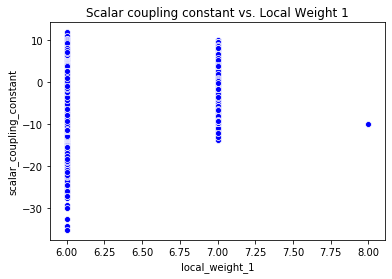

In [21]:
sns.scatterplot(x = 'local_weight_1', y='scalar_coupling_constant',data=train_df_2jhh[['scalar_coupling_constant', 'local_weight_1']], color = 'blue')
plt.title("Scalar coupling constant vs. Local Weight 1")
plt.show()

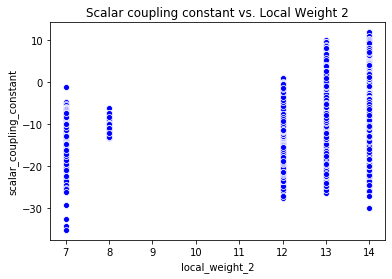

In [22]:
sns.scatterplot(x = 'local_weight_2', y='scalar_coupling_constant',data=train_df_2jhh[['scalar_coupling_constant', 'local_weight_2']], color = 'blue')
plt.title("Scalar coupling constant vs. Local Weight 2")
plt.show()

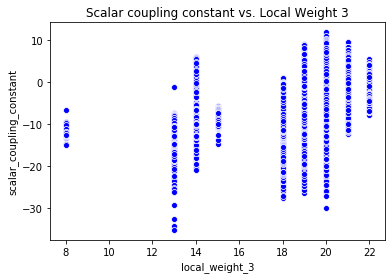

In [23]:
sns.scatterplot(x = 'local_weight_3', y='scalar_coupling_constant',data=train_df_2jhh[['scalar_coupling_constant', 'local_weight_3']], color = 'blue')
plt.title("Scalar coupling constant vs. Local Weight 3")
plt.show()

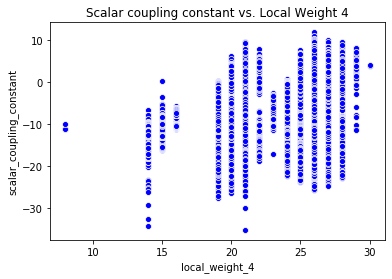

In [24]:
sns.scatterplot(x = 'local_weight_4', y='scalar_coupling_constant',data=train_df_2jhh[['scalar_coupling_constant', 'local_weight_4']], color = 'blue')
plt.title("Scalar coupling constant vs. Local Weight 4")
plt.show()

There appears to be good separation of classes based on local weights!

Feature 4: Number of Paths of Length 2

We again consider the complete graph on the atoms in a given molecule. We may think of this as the weighted complete adjacency graph on the atoms in the molecule, where the weight on an edge is given by the physical distance. For a coupling pair in question, we calculate the number of paths in the graph which traverse exactly two edges to get from atom_1 to atom_0. We count how many of these there are whose length is less than a prescribed value epsilon.

In [25]:
## Add pairwise distances between all atoms in a molecule to the train data
n_atoms=7
train_df_1jhn = B.build_couple_dataframe_with_dists(train_df,structures_csv,coupling_type = '1JHN', n_atoms = 7)

#Number of 2-edge paths between bonding pair (such that path is contained in epsilon ball)
def add_2_edge_paths(df, epsilon, n_atoms):
    # requires epsilon >=1 to be topological
    # Consider all edges corresponding to distances from  vertices to vertex 0
    edges = df[[f'd_{n}_0' for n in range(2, n_atoms)]].copy(deep=True)
    edges['d_1_1'] = df['d_1_0']
    edges[[f'd_{n}_1' for n in range(2, n_atoms)]] = df[[f'd_{n}_1' for n in range(2, n_atoms)]]
    for n in range(2, n_atoms):
        edges[f'd_{n}_0'] = np.where((edges[f'd_{n}_0'] + edges[f'd_{n}_1']) <= edges['d_1_1'].multiply(epsilon), 1, 0)
    edges.drop([f'd_{n}_1' for n in range(1, n_atoms)], axis=1)
    num_two_edge_paths = edges.sum(axis=1)

    df[f'num_two_edge_paths_{epsilon}'] = num_two_edge_paths

In [26]:
add_2_edge_paths(train_df_1jhn,1,n_atoms)
add_2_edge_paths(train_df_1jhn,2,n_atoms)
add_2_edge_paths(train_df_1jhn,3,n_atoms)
add_2_edge_paths(train_df_1jhn,4,n_atoms)


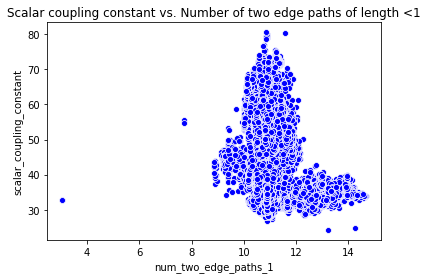

In [27]:
sns.scatterplot(x = 'num_two_edge_paths_1', y='scalar_coupling_constant',data=train_df_1jhn[['scalar_coupling_constant', 'num_two_edge_paths_1']], color = 'blue')
plt.title("Scalar coupling constant vs. Number of two edge paths of length <1")
plt.show()

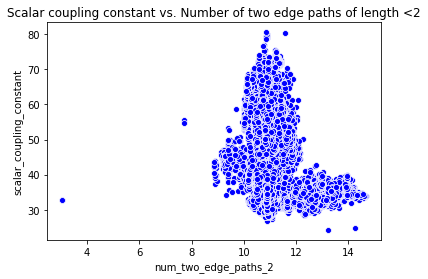

In [28]:
sns.scatterplot(x = 'num_two_edge_paths_2', y='scalar_coupling_constant',data=train_df_1jhn[['scalar_coupling_constant', 'num_two_edge_paths_2']], color = 'blue')
plt.title("Scalar coupling constant vs. Number of two edge paths of length <2")
plt.show()

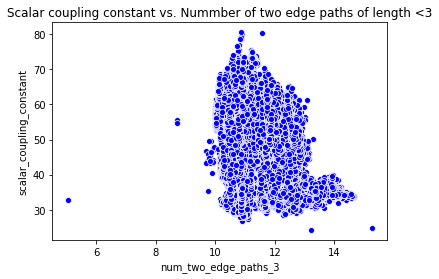

In [29]:
sns.scatterplot(x = 'num_two_edge_paths_3', y='scalar_coupling_constant',data=train_df_1jhn[['scalar_coupling_constant', 'num_two_edge_paths_3']], color = 'blue')
plt.title("Scalar coupling constant vs. Nummber of two edge paths of length <3")
plt.show()

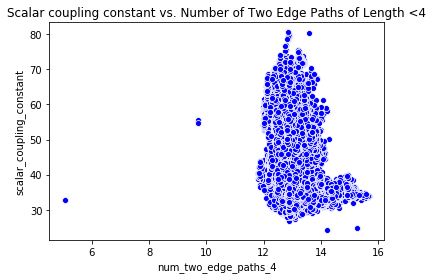

In [30]:
sns.scatterplot(x = 'num_two_edge_paths_4', y='scalar_coupling_constant',data=train_df_1jhn[['scalar_coupling_constant', 'num_two_edge_paths_4']], color = 'blue')
plt.title("Scalar coupling constant vs. Number of Two Edge Paths of Length <4")
plt.show()

Fiarly nice separation of scalar coupling constant for large values of num_two_edges!